## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [22]:
# initialize input array
input1 = np.array([[1, 2, 1], [1, 3, 5], [7, 1, 1]])
start_1 = [0, 0]
end_1 = [2, 2]
# input1 = np.array([[1,2,1,6],[1,3,5,3],[7,1,4,1]])
# start_1 = [0,0]
# end_1 = [2,3]
# input1 = np.array([[1,3,7,2,1],[3,1,5,3,1],[3,2,6,1,2],[3,1,5,6,1],[2,2,1,1,2]])
# start_1 = [2,0]
# end_1 = [0,4]

### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. 
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

In [23]:
model = nengo.Network(label="Mercier Lab2")

with model:
    # send input pulse
    input_node = nengo.Node(Piecewise({0: 1, 0.25: 0}))

In [24]:
with model:
    length = len(input1.ravel())
    # obtain row and col for input array
    row, col = np.shape(input1)
    neuron1_col = []
    neuron1 = []
    for i in range(0, row):
        for j in range(0, col):
            # append to column list
            neuron1_col.append(nengo.Ensemble(n_neurons=50, dimensions=1))
        # append column list to full neuron ensemble list
        neuron1.append(neuron1_col)
        # reset column list
        neuron1_col = []

In [25]:
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))
        self.started_spiking = False
        self.finished = False

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        # determine when spike starts
        if self.history[0] > 0.8 and ~self.started_spiking:
            self.started_spiking = True
        # determine when spike ends
        if self.started_spiking == True and self.history[0] < 0.25:
            self.finished = True
        # if done -> inhibition
        if self.finished == True:
            return 0
        else:
            return self.history[0]


with model:
    dt = 0.001
    delaynode = []
    delay_col = []
    for i in range(0, row):
        for j in range(0, col):
            # 1 second represents 1 weighted value
            time_delay = input1[i][j]
            delay = Delay(1, timesteps=int(time_delay / dt))
            delay_col.append(nengo.Node(delay.step, size_in=1, size_out=1))
        delaynode.append(delay_col)
        delay_col = []

In [26]:
with model:
    # send input pulse into start location delay node
    nengo.Connection(input_node, delaynode[start_1[0]][start_1[1]])
    for i in range(0, row):
        for j in range(0, col):
            # for every location, connect delay to the neuron
            nengo.Connection(delaynode[i][j], neuron1[i][j])

            # top left
            if i == 0 and j == 0:
                nengo.Connection(neuron1[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j + 1])

            # top right
            elif i == 0 and j == (len(neuron1[i]) - 1):
                nengo.Connection(neuron1[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j])

            # bottom left
            elif i == (len(neuron1) - 1) and j == 0:
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j + 1])

            # bottom right
            elif i == (len(neuron1) - 1) and j == (len(neuron1[i]) - 1):
                nengo.Connection(neuron1[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j])

            # top row
            elif i == 0:
                nengo.Connection(neuron1[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j + 1])

            # bottom row
            elif i == (len(neuron1) - 1):
                nengo.Connection(neuron1[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j + 1])

            # left column
            elif j == 0:
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j + 1])

            # right column
            elif j == (len(neuron1[i]) - 1):
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j - 1])

            # else (middle blocks)
            else:
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i - 1][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i][j + 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j - 1])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j])
                nengo.Connection(neuron1[i][j], delaynode[i + 1][j + 1])

### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

In [27]:
# probe
with model:
    neuron_probe = []
    delay_probe = []
    for i in range(0, row):
        for j in range(0, col):
            neuron_probe.append(nengo.Probe(neuron1[i][j], synapse=0.01))
            delay_probe.append(nengo.Probe(delaynode[i][j], synapse=0.01))

In [28]:
sim_time = 5
with nengo.Simulator(model) as sim:
    # run for 3 seconds
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Neuron Output')

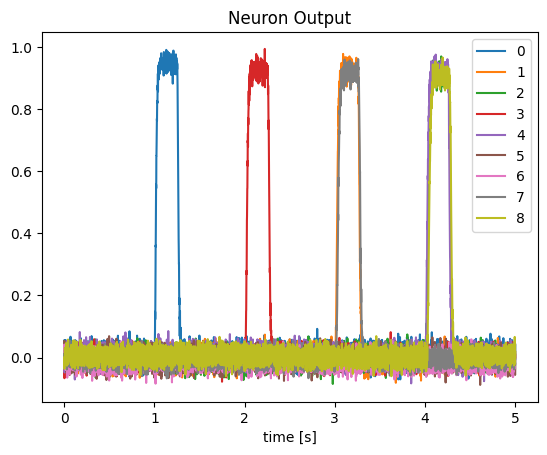

In [29]:
plt.figure()
# plt.plot(sim.trange(), sim.data[neuron_probe[10]])
# plt.plot(sim.trange(), sim.data[delay_probe[0]])
# plt.plot(sim.trange(), sim.data[neuron_probe[4]])
# plt.plot(sim.trange(), sim.data[neuron_probe[7]])
# plt.plot(sim.trange(), sim.data[neuron_probe[1]])
# plt.plot(sim.trange(), sim.data[neuron_probe[8]])
for i in range(0, len(neuron_probe)):
    plt.plot(sim.trange(), sim.data[neuron_probe[i]], label=i)
plt.xlabel("time [s]")
plt.legend()
plt.title("Neuron Output")

In [30]:
aer_tab = []
spikes_tab = []
first_tab = []
for i in range(0, len(neuron_probe)):
    aer = sim.data[neuron_probe[i]][:, 0] > 0.5
    spikes_locs = np.where(aer == True)
    if np.asarray(spikes_locs).size == 0:
        first_spike = sim_time / dt
    else:
        first_spike = np.min(spikes_locs)

    first_tab.append(first_spike)

    print(
        "This is time step where map location ", i + 1, " first begins: ", first_spike
    )
    dt = 0.001
    print("This time step occurs at approximately ", first_spike * dt, " seconds")

This is time step where map location  1  first begins:  1018
This time step occurs at approximately  1.018  seconds
This is time step where map location  2  first begins:  3026
This time step occurs at approximately  3.0260000000000002  seconds
This is time step where map location  3  first begins:  4037
This time step occurs at approximately  4.037  seconds
This is time step where map location  4  first begins:  2029
This time step occurs at approximately  2.029  seconds
This is time step where map location  5  first begins:  4028
This time step occurs at approximately  4.0280000000000005  seconds
This is time step where map location  6  first begins:  5000.0
This time step occurs at approximately  5.0  seconds
This is time step where map location  7  first begins:  5000.0
This time step occurs at approximately  5.0  seconds
This is time step where map location  8  first begins:  3038
This time step occurs at approximately  3.0380000000000003  seconds
This is time step where map locat

### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path

In [31]:
tab = []
tabcol = []
colset = 0
colend = col
for i in range(0, row):
    for j in range(colset, colend):
        tabcol.append(first_tab[j])
    colset += col
    colend += col
    tab.append(tabcol)
    tabcol = []

last = end_1
path = []
# history used to ensure prev value isn't looked at
history = tab[end_1[0]][end_1[1]]
path.append(end_1)
last_diff = 0
# run backwards until start location reached
while last != start_1:
    mins = []
    index_val = []

    # top left
    if last[0] == 0 and last[1] == 0:
        mins.append(tab[last[0]][last[1] + 1])
        mins.append(tab[last[0] + 1][last[1] + 1])
        mins.append(tab[last[0] + 1][last[1]])

        index_val.append([last[0], last[1] + 1])
        index_val.append([last[0] + 1, last[1] + 1])
        index_val.append([last[0] + 1, last[1]])
    # top right
    elif last[0] == 0 and last[1] == (len(tab[0]) - 1):
        mins.append(tab[last[0]][last[1] - 1])
        mins.append(tab[last[0] + 1][last[1] - 1])
        mins.append(tab[last[0] + 1][last[1]])

        index_val.append([last[0], last[1] - 1])
        index_val.append([last[0] + 1, last[1] - 1])
        index_val.append([last[0] + 1, last[1]])
    # bottom left
    elif last[0] == (len(tab) - 1) and last[1] == 0:
        mins.append(tab[last[0]][last[1] + 1])
        mins.append(-tab[last[0] - 1][last[1] + 1])
        mins.append(tab[last[0] - 1][last[1]])

        index_val.append([last[0], last[1] + 1])
        index_val.append([last[0] - 1, last[1] + 1])
        index_val.append([last[0] - 1, last[1]])
    # bottom right
    elif last[0] == (len(tab) - 1) and last[1] == (len(tab[last[0]]) - 1):
        mins.append(tab[last[0]][last[1] - 1])
        mins.append(tab[last[0] - 1][last[1] - 1])
        mins.append(tab[last[0] - 1][last[1]])

        index_val.append([last[0], last[1] - 1])
        index_val.append([last[0] - 1, last[1] - 1])
        index_val.append([last[0] - 1, last[1]])

    # top row
    elif last[0] == 0:
        mins.append(tab[last[0]][last[1] - 1])
        mins.append(tab[last[0] + 1][last[1] - 1])
        mins.append(tab[last[0] + 1][last[1]])
        mins.append(tab[last[0] + 1][last[1] + 1])
        mins.append(tab[last[0]][last[1] + 1])

        index_val.append([last[0], last[1] - 1])
        index_val.append([last[0] + 1, last[1] - 1])
        index_val.append([last[0] + 1, last[1]])
        index_val.append([last[0] + 1, last[1] + 1])
        index_val.append([last[0], last[1] + 1])

    # bottom row
    elif last[0] == (len(tab) - 1):
        mins.append(tab[last[0]][last[1] - 1])
        mins.append(tab[last[0] - 1][last[1] - 1])
        mins.append(tab[last[0] - 1][last[1]])
        mins.append(tab[last[0] - 1][last[1] + 1])
        mins.append(tab[last[0]][last[1] + 1])

        index_val.append([last[0], last[1] - 1])
        index_val.append([last[0] - 1, last[1] - 1])
        index_val.append([last[0] - 1, last[1]])
        index_val.append([last[0] - 1, last[1] + 1])
        index_val.append([last[0], last[1] + 1])

    # left column
    elif last[1] == 0:
        mins.append(tab[last[0] - 1][last[1]])
        mins.append(tab[last[0] + 1][last[1]])
        mins.append(tab[last[0] - 1][last[1] + 1])
        mins.append(tab[last[0]][last[1] + 1])
        mins.append(tab[last[0] + 1][last[1] + 1])

        index_val.append([last[0] - 1, last[1]])
        index_val.append([last[0] + 1, last[1]])
        index_val.append([last[0] - 1, last[1] + 1])
        index_val.append([last[0], last[1] + 1])
        index_val.append([last[0] + 1, last[1] + 1])

    # right column
    elif last[1] == (len(tab[last[0]]) - 1):
        mins.append(tab[last[0] - 1][last[1]])
        mins.append(tab[last[0] + 1][last[1]])
        mins.append(tab[last[0] - 1][last[1] - 1])
        mins.append(tab[last[0]][last[1] - 1])
        mins.append(tab[last[0] + 1][last[1] - 1])

        index_val.append([last[0] - 1, last[1]])
        index_val.append([last[0] + 1, last[1]])
        index_val.append([last[0] - 1, last[1] - 1])
        index_val.append([last[0], last[1] - 1])
        index_val.append([last[0] + 1, last[1] - 1])

    # else (middle blocks)
    else:
        mins.append(tab[last[0] - 1][last[1]])
        mins.append(tab[last[0] + 1][last[1]])
        mins.append(tab[last[0] - 1][last[1] + 1])
        mins.append(tab[last[0]][last[1] + 1])
        mins.append(tab[last[0] + 1][last[1] + 1])
        mins.append(tab[last[0] - 1][last[1] - 1])
        mins.append(tab[last[0]][last[1] - 1])
        mins.append(tab[last[0] + 1][last[1] - 1])

        index_val.append([last[0] - 1, last[1]])
        index_val.append([last[0] + 1, last[1]])
        index_val.append([last[0] - 1, last[1] + 1])
        index_val.append([last[0], last[1] + 1])
        index_val.append([last[0] + 1, last[1] + 1])
        index_val.append([last[0] - 1, last[1] - 1])
        index_val.append([last[0], last[1] - 1])
        index_val.append([last[0] + 1, last[1] - 1])

    temp_list = []
    # look at the mins, if the value is greater than or equal to 0 and not the prev value, append to list
    for i in mins:
        if i >= 0:
            if i != history:
                temp_list.append(i)
    # reset history
    history = tab[last[0]][last[1]]
    # look at index_val array at the index in the mins array where the minimum of the temp_list occurs and append to path
    path.append(index_val[mins.index(min(temp_list))])
    last = index_val[mins.index(min(temp_list))]


path.reverse()
print("The optimal path is: ", path)

The optimal path is:  [[0, 0], [1, 0], [2, 1], [2, 2]]
